In [15]:
import xarray as xr
import numpy as np
import xwrf
import xgcm
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt

In [2]:
P_LEVELS = np.array([50, 100, 250, 500, 850])

In [49]:
def interpolate_variable(variable, air_pressure, grid):
    """
    relevant xgcm documentation: https://xgcm.readthedocs.io/en/latest/transform.html
    :variable   : ds_pp[var]
    :air_pressure   : ds_pp.air_pressure / 100.0  (conversion from Pa to hPa)
    :grid   :   xgcm.Grid(ds_pp, periodic=False)

    """
    return grid.transform(
        variable,
        "Z",
        P_LEVELS,
        target_data=air_pressure,
        method="log",
        mask_edges=False,  # if set to 'False' value outside the range of target will be filled with the nearest valid value
    )


def quantify_variable(variable, unit):
    variables_with_units = variable * unit
    return variables_with_units.metpy.quantify()

def calculate_sea_level_pressure(
    elevations, surface_pressure, air_temperature_2m, q_2m
):
    ideal_gas_constant = 29.3  # m/K

    virtual_temp_2m = mpcalc.virtual_temperature(air_temperature_2m, q_2m)
    virtual_temp_2m_with_lapse_rt = (
        virtual_temp_2m.values + 0.0065 * elevations
    )  # lapse rate of 6.5 K/km

    slp = surface_pressure * np.exp(
        elevations / (ideal_gas_constant * virtual_temp_2m_with_lapse_rt)
    )

    # Add the units
    slp_units = slp * units("Pa")
    slp_units.metpy.quantify()

    # add to our dataset
    return slp_units

def calculate_total_rain(ds):
    """
    RAINNC: ACCUMULATED TOTAL GRID SCALE PRECIPITATION
    RAINC: ACCUMULATED TOTAL CUMULUS PRECIPITATION 
    RAINSH: ACCUMULATED SHALLOW CUMULUS PRECIPITATION
    """
    
    tp_6h = ds.RAINNC.diff(dim='XTIME') # 6h accumulation
    tp_6h = tp_6h.reindex(XTIME=ds.XTIME, fill_value=float('nan'))
    
    tp_6h.name = "tp_6h"
    tp_6h.attrs["units"] = "mm"
    tp_6h.attrs["description"] = "6-hour accumulated precipitation"

    return tp_6h

In [21]:
FOLDER_NAME = '../data/wrf_data'
raw_wrfout = xr.open_dataset(f"{FOLDER_NAME}/output_23040400.nc")

In [22]:
raw_wrfout.dims

FrozenMappingWarningOnValuesAccess({'XTIME': 14, 'south_north': 426, 'west_east': 303, 'bottom_top': 54, 'bottom_top_stag': 55, 'soil_layers_stag': 4, 'west_east_stag': 304, 'south_north_stag': 427, 'seed_dim_stag': 2})

In [23]:
pp_wrfout = raw_wrfout.xwrf.postprocess()
ds_wrfout = pp_wrfout.xwrf.destagger()

In [24]:
ds_wrfout

<xarray.Dataset> Size: 10GB
Dimensions:                    (XTIME: 14, y: 426, x: 303, soil_layers: 3,
                                z: 54, seed_dim: 1, x_stag: 304, y_stag: 427,
                                z_stag: 55, Time: 14)
Coordinates: (12/15)
  * XTIME                      (XTIME) datetime64[ns] 112B 2023-04-04T06:00:0...
  * y                          (y) float64 3kB -3.28e+06 ... -2.005e+06
  * x                          (x) float64 2kB -2.247e+06 ... -1.341e+06
  * z                          (z) float32 216B 0.9969 0.9899 ... 0.001747
  * x_stag                     (x_stag) float64 2kB -2.249e+06 ... -1.34e+06
  * y_stag                     (y_stag) float64 3kB -3.281e+06 ... -2.003e+06
    ...                         ...
    XLONG                      (y, x) float32 516kB ...
    XLAT                       (y, x) float32 516kB ...
    XLONG_U                    (y, x_stag) float32 518kB ...
    XLAT_U                     (y, x_stag) float32 518kB ...
    XLONG_V                    (y_stag, x) float32 518kB ...
    XLAT_V                     (y_stag, x) float32 518kB ...
Dimensions without coordinates: soil_layers, seed_dim
Data variables: (12/208)
    LU_INDEX                   (XTIME, y, x) float32 7MB ...
    ZS                         (XTIME, soil_layers) float32 168B 0.15 ... 1.1
    DZS                        (XTIME, soil_layers) float32 168B 0.2 ... 0.8
    VAR_SSO                    (XTIME, y, x) float32 7MB ...
    U                          (XTIME, z, y, x) float32 390MB 1.253 ... 9.471
    V                          (XTIME, z, y, x) float32 390MB -9.495 ... 4.303
    ...                         ...
    geopotential_height        (XTIME, z, y, x) float32 390MB 24.62 ... 2e+04
    wind_east                  (XTIME, z, y, x) float32 390MB 6.401 ... 5.48
    wind_north                 (XTIME, z, y, x) float32 390MB -7.124 ... 8.843
    wind_east_10               (XTIME, y, x) float32 7MB 5.984 5.463 ... 3.816
    wind_north_10              (XTIME, y, x) float32 7MB -6.655 ... 0.9929
    wrf_projection             object 8B +proj=stere +x_0=0 +y_0=0 +a=6370000...
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-04-04_03:00:00
    SIMULATION_START_DATE:           2023-04-04_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Sat Jan 10 13:47:00 2026: cdo -L mergeti...
    CDO:                             Climate Data Operators version 2.5.0 (ht...

In [34]:
ds_wrfout.XTIME

<xarray.DataArray 'XTIME' (XTIME: 14)> Size: 112B
array(['2023-04-04T06:00:00.000000000', '2023-04-04T12:00:00.000000000',
       '2023-04-04T18:00:00.000000000', '2023-04-05T00:00:00.000000000',
       '2023-04-05T06:00:00.000000000', '2023-04-05T12:00:00.000000000',
       '2023-04-05T18:00:00.000000000', '2023-04-06T00:00:00.000000000',
       '2023-04-06T06:00:00.000000000', '2023-04-06T12:00:00.000000000',
       '2023-04-06T18:00:00.000000000', '2023-04-07T00:00:00.000000000',
       '2023-04-07T06:00:00.000000000', '2023-04-07T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 112B 2023-04-04T06:00:00 ... 2023-04-07T1...
Attributes:
    standard_name:  time
    axis:           T

 - min:  -4.656613e-10
 - max:  186.73819
 - mean:  4.842432
 - std:  10.818562
 - min:  0.0
 - max:  64.50249
 - mean:  1.0584311
 - std:  2.7410734
<xarray.DataArray 'RAINNC' (y: 426, x: 303)> Size: 516kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(426, 303), dtype=float32)
Coordinates:
  * y        (y) float64 3kB -3.28e+06 -3.277e+06 ... -2.008e+06 -2.005e+06
  * x        (x) float64 2kB -2.247e+06 -2.244e+06 ... -1.344e+06 -1.341e+06
    XTIME    datetime64[ns] 8B 2023-04-04T06:00:00
    CLAT     (y, x) float32 516kB 44.81 44.83 44.85 44.87 ... 61.63 61.64 61.66
    XLONG    (y, x) float32 516kB ...
    XLAT     (y, x) float32 516kB ...
Attributes:
    units:          mm
    FieldType:      104
    MemoryOrder:    XY 
    description:    A

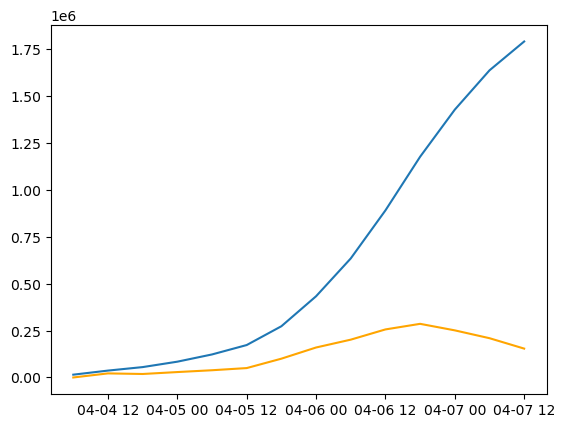

In [47]:
print(' - min: ', ds_wrfout.RAINNC.values.min())
print(' - max: ', ds_wrfout.RAINNC.values.max())
print(' - mean: ', ds_wrfout.RAINNC.values.mean())
print(' - std: ', ds_wrfout.RAINNC.values.std())


tp_6h = ds_wrfout.RAINNC.diff(dim='XTIME')
tp_6h.XTIME
print(' - min: ', tp_6h.values.min())
print(' - max: ', tp_6h.values.max())
print(' - mean: ', tp_6h.values.mean())
print(' - std: ', tp_6h.values.std())
tp_6h = tp_6h.reindex(XTIME=ds_wrfout.XTIME, fill_value=float('nan'))

plt.plot(ds_wrfout.XTIME, ds_wrfout.RAINNC.sum(dim=['x','y']))
plt.plot(tp_6h.XTIME, tp_6h.sum(dim=['x','y']), color='orange')

print(tp_6h.sel(XTIME='2023-04-04T06:00:00.000000000'))

In [50]:
def process_raw_wrfout_test():
    FOLDER_NAME = '../data/wrf_data'
    raw_wrfout = xr.open_dataset(f"{FOLDER_NAME}/output_23040400.nc")
    pp_wrfout = raw_wrfout.xwrf.postprocess()
    ds_wrfout = pp_wrfout.xwrf.destagger()

    # interpolate variables
    processed_variables = {}
    air_pressure = ds_wrfout.air_pressure / 100.0
    grid = xgcm.Grid(ds_wrfout, periodic=False)
    pressure_level_variables = ["U", "V", "geopotential", "air_potential_temperature"]

    for var in pressure_level_variables:
        processed_variables[var] = interpolate_variable(
            variable=ds_wrfout[var], air_pressure=air_pressure, grid=grid
        )

    air_temperature = mpcalc.temperature_from_potential_temperature(
        pressure=P_LEVELS * units("hPa"),
        potential_temperature=quantify_variable(processed_variables["air_potential_temperature"], units.kelvin),
    )
    air_temperature = air_temperature.transpose(
        "XTIME", ..., "air_pressure"
    )

    mean_sea_level_pressure = calculate_sea_level_pressure(
        elevations=ds_wrfout.HGT,
        surface_pressure=ds_wrfout.PSFC * units('Pa'),
        air_temperature_2m=ds_wrfout['T2'],
        q_2m=quantify_variable(ds_wrfout['Q2'], units('kg/kg'))
    )

    print('calculate msl')

    acc_precip_6h = calculate_total_rain(ds_wrfout)

    print('calculate acc_precip_6h')

    dataset = xr.Dataset({
        "geopotential": processed_variables["geopotential"],
        "u": processed_variables['U'],
        "v": processed_variables['V'],
        "t": air_temperature,
        "10u": ds_wrfout['U10'],
        "10v": ds_wrfout['U10'],
        "2t": ds_wrfout['T2'],
        "msl": mean_sea_level_pressure,
        "tp": acc_precip_6h,
    })

    return dataset

In [51]:
dataset = process_raw_wrfout_test()

calculate msl
calculate acc_precip_6h


In [52]:
dataset

<xarray.Dataset> Size: 327MB
Dimensions:       (y: 426, x: 303, XTIME: 14, air_pressure: 5)
Coordinates:
  * y             (y) float64 3kB -3.28e+06 -3.277e+06 ... -2.008e+06 -2.005e+06
  * x             (x) float64 2kB -2.247e+06 -2.244e+06 ... -1.341e+06
  * XTIME         (XTIME) datetime64[ns] 112B 2023-04-04T06:00:00 ... 2023-04...
  * air_pressure  (air_pressure) int64 40B 50 100 250 500 850
    CLAT          (y, x) float32 516kB 44.81 44.83 44.85 ... 61.63 61.64 61.66
    XLONG         (y, x) float32 516kB -124.4 -124.4 -124.3 ... -123.8 -123.8
    XLAT          (y, x) float32 516kB 44.81 44.83 44.85 ... 61.63 61.64 61.66
Data variables:
    geopotential  (XTIME, y, x, air_pressure) float64 72MB 1.976e+05 ... 1.23...
    u             (XTIME, y, x, air_pressure) float64 72MB 3.725 1.114 ... 5.296
    v             (XTIME, y, x, air_pressure) float64 72MB -7.732 ... 1.266
    t             (XTIME, y, x, air_pressure) float64 72MB <Quantity([[[[213....
    10u           (XTIME, y, x) float32 7MB ...
    10v           (XTIME, y, x) float32 7MB ...
    2t            (XTIME, y, x) float32 7MB ...
    msl           (XTIME, y, x) float32 7MB <Quantity([[[102298.32  102294.55...
    tp            (XTIME, y, x) float32 7MB nan nan nan nan ... 0.0 0.0 0.0 0.0

(14,)
(14,)


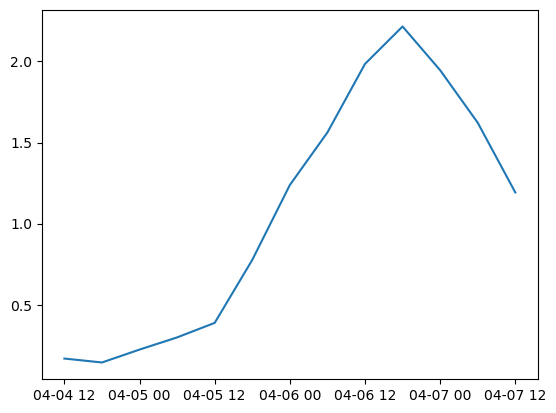

In [54]:
print(dataset.XTIME.shape)
print(dataset.tp.sum(dim=['x','y']).shape)
plt.plot(dataset.XTIME, dataset.tp.mean(dim=['x','y']))

In [2]:
FOLDER_NAME = '../data/wrf_data'
FILE_NAME = 'wrfout_d02_sfc_merged_23011300.nc/merged.nc'

In [9]:
raw_wrfout = xr.open_dataset(f"{FOLDER_NAME}/{FILE_NAME}")

In [10]:
raw_wrfout

<xarray.Dataset> Size: 297MB
Dimensions:   (XTIME: 82, south_north: 426, west_east: 303)
Coordinates:
  * XTIME     (XTIME) datetime64[ns] 656B 2023-01-13T03:00:00 ... 2023-01-16T...
    XLONG     (south_north, west_east) float32 516kB ...
    XLAT      (south_north, west_east) float32 516kB ...
Dimensions without coordinates: south_north, west_east
Data variables:
    T2        (XTIME, south_north, west_east) float32 42MB ...
    U10       (XTIME, south_north, west_east) float32 42MB ...
    V10       (XTIME, south_north, west_east) float32 42MB ...
    SINALPHA  (XTIME, south_north, west_east) float32 42MB ...
    COSALPHA  (XTIME, south_north, west_east) float32 42MB ...
    RAINC     (XTIME, south_north, west_east) float32 42MB ...
    RAINNC    (XTIME, south_north, west_east) float32 42MB ...
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-01-13_03:00:00
    SIMULATION_START_DATE:           2023-01-13_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Fri Jan 09 11:51:49 2026: cdo -L mergeti...
    CDO:                             Climate Data Operators version 2.5.0 (ht...

In [11]:
pp_wrfout = raw_wrfout.xwrf.postprocess()
pp_wrfout

<xarray.Dataset> Size: 382MB
Dimensions:         (XTIME: 82, y: 426, x: 303, Time: 82)
Coordinates:
  * XTIME           (XTIME) datetime64[ns] 656B 2023-01-13T03:00:00 ... 2023-...
  * y               (y) float64 3kB -3.28e+06 -3.277e+06 ... -2.005e+06
  * x               (x) float64 2kB -2.247e+06 -2.244e+06 ... -1.341e+06
  * Time            (Time) datetime64[ns] 656B 2023-01-13T03:00:00 ... 2023-0...
    XLONG           (y, x) float32 516kB ...
    XLAT            (y, x) float32 516kB ...
Data variables:
    T2              (XTIME, y, x) float32 42MB ...
    U10             (XTIME, y, x) float32 42MB ...
    V10             (XTIME, y, x) float32 42MB ...
    SINALPHA        (XTIME, y, x) float32 42MB ...
    COSALPHA        (XTIME, y, x) float32 42MB ...
    RAINC           (XTIME, y, x) float32 42MB ...
    RAINNC          (XTIME, y, x) float32 42MB ...
    wind_east_10    (XTIME, y, x) float32 42MB 1.656 1.307 ... 1.435 1.375
    wind_north_10   (XTIME, y, x) float32 42MB 5.109 4.852 ... 1.243 0.6079
    wrf_projection  object 8B +proj=stere +x_0=0 +y_0=0 +a=6370000 +b=6370000...
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-01-13_03:00:00
    SIMULATION_START_DATE:           2023-01-13_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Fri Jan 09 11:51:49 2026: cdo -L mergeti...
    CDO:                             Climate Data Operators version 2.5.0 (ht...

In [12]:
ds_wrfout = pp_wrfout.xwrf.destagger()
ds_wrfout

<xarray.Dataset> Size: 382MB
Dimensions:         (XTIME: 82, y: 426, x: 303, Time: 82)
Coordinates:
  * XTIME           (XTIME) datetime64[ns] 656B 2023-01-13T03:00:00 ... 2023-...
  * y               (y) float64 3kB -3.28e+06 -3.277e+06 ... -2.005e+06
  * x               (x) float64 2kB -2.247e+06 -2.244e+06 ... -1.341e+06
  * Time            (Time) datetime64[ns] 656B 2023-01-13T03:00:00 ... 2023-0...
    XLONG           (y, x) float32 516kB ...
    XLAT            (y, x) float32 516kB ...
Data variables:
    T2              (XTIME, y, x) float32 42MB ...
    U10             (XTIME, y, x) float32 42MB ...
    V10             (XTIME, y, x) float32 42MB ...
    SINALPHA        (XTIME, y, x) float32 42MB ...
    COSALPHA        (XTIME, y, x) float32 42MB ...
    RAINC           (XTIME, y, x) float32 42MB ...
    RAINNC          (XTIME, y, x) float32 42MB ...
    wind_east_10    (XTIME, y, x) float32 42MB 1.656 1.307 ... 1.435 1.375
    wind_north_10   (XTIME, y, x) float32 42MB 5.109 4.852 ... 1.243 0.6079
    wrf_projection  object 8B +proj=stere +x_0=0 +y_0=0 +a=6370000 +b=6370000...
Attributes: (12/136)
    CDI:                             Climate Data Interface version 2.5.0 (ht...
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2023-01-13_03:00:00
    SIMULATION_START_DATE:           2023-01-13_00:00:00
    WEST-EAST_GRID_DIMENSION:        304
    ...                              ...
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Fri Jan 09 11:51:49 2026: cdo -L mergeti...
    CDO:                             Climate Data Operators version 2.5.0 (ht...

In [14]:
print(ds_wrfout.Time)

<xarray.DataArray 'Time' (Time: 82)> Size: 656B
array(['2023-01-13T03:00:00.000000000', '2023-01-13T04:00:00.000000000',
       '2023-01-13T05:00:00.000000000', '2023-01-13T06:00:00.000000000',
       '2023-01-13T07:00:00.000000000', '2023-01-13T08:00:00.000000000',
       '2023-01-13T09:00:00.000000000', '2023-01-13T10:00:00.000000000',
       '2023-01-13T11:00:00.000000000', '2023-01-13T12:00:00.000000000',
       '2023-01-13T13:00:00.000000000', '2023-01-13T14:00:00.000000000',
       '2023-01-13T15:00:00.000000000', '2023-01-13T16:00:00.000000000',
       '2023-01-13T17:00:00.000000000', '2023-01-13T18:00:00.000000000',
       '2023-01-13T19:00:00.000000000', '2023-01-13T20:00:00.000000000',
       '2023-01-13T21:00:00.000000000', '2023-01-13T22:00:00.000000000',
       '2023-01-13T23:00:00.000000000', '2023-01-14T00:00:00.000000000',
       '2023-01-14T01:00:00.000000000', '2023-01-14T02:00:00.000000000',
       '2023-01-14T03:00:00.000000000', '2023-01-14T04:00:00.000000000',
   

In [ ]:
def process_raw_wrfout(model, id):
    FOLDER_NAME = f"/archives/forecasts/{model}/{id}"
    raw_wrfout = xr.open_dataset(f"{FOLDER_NAME}/merged.nc")
    pp_wrfout = raw_wrfout.xwrf.postprocess()
    ds_wrfout = pp_wrfout.xwrf.destagger()

    # interpolate variables
    processed_variables = {}
    air_pressure = ds_wrfout.air_pressure / 100.0
    grid = xgcm.Grid(ds_wrfout, periodic=False)
    pressure_level_variables = ["U", "V", "geopotential", "air_potential_temperature", "Q2"]

    for var in pressure_level_variables:
        processed_variables[var] = interpolate_variable(
            variable=ds_wrfout[var], air_pressure=air_pressure, grid=grid
        )

    air_temperature = mpcalc.temperature_from_potential_temperature(
        pressure=air_pressure * units("hPa"),
        potential_temperature=processed_variables["air_potential_temperature"],
    )
    mean_sea_level_pressure = calculate_sea_level_pressure(
        elevations=ds_wrfout.HGT,
        surface_pressure=ds_wrfout.PSFC * units('Pa'),
        air_temperature_2m=ds_wrfout['T2'],
        q_2m=processed_variables['Q2']
    )

    acc_precip_6h = calculate_total_rain(ds_wrfout)

    dataset = {
        "geopotential": processed_variables["geopotential"],
        "u": processed_variables['U'],
        "v": processed_variables['V'],
        "t": air_temperature,
        "10u": ds_wrfout['U10'],
        "10v": ds_wrfout['U10'],
        "2t": ds_wrfout['T2'],
        "msl": mean_sea_level_pressure,
        "tp": acc_precip_6h,
    }

    dataset = dataset.rename(
        {
            "XLONG": "longitude",
            "XLAT": "latitude",
            "air_pressure": "level",
            "Time": "time",
        }
    )

    dataset.to_netcdf(f"{FOLDER_NAME}/wrfout_d02_processed_{id}.nc", mode='w')

